- Student ID: 224234147
- Name: M.RACHEL
- Attempting high Distinction Question: Yes

_________________________________________

- Student ID: 224234666
- Name: NEHA KAPLISH
- Attempting high Distinction Question: Yes

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
import findspark

In [3]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"
findspark.init()


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col
from pyspark.sql.functions import col, expr
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, association_rules
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
import warnings

In [5]:
# suppress all warnings:
warnings.filterwarnings('ignore')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
#mount the drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Initialize Spark session
spark = SparkSession.builder.appName('transaction_data').getOrCreate()


In [8]:
# Load the dataset
file_path = "/transactionrecord.gz"  # adjust if necessary
spark_df = spark.read.csv(file_path, header=True, inferSchema=True)

spark_df.show(5)

+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

#Part 1

##Question 1.1

Using PySpark to do some of the data wrangling process, so that:



### Question 1.1.1
Replace 'NA' in CustomerNo with '-1'.



In [9]:
# Task 1.1.1: Replace 'NA' in CustomerNo with '-1'
# Here we are simply replacing NA with -1
spark_df = spark_df.withColumn("CustomerNo", regexp_replace(col("CustomerNo"), "NA", "-1"))
spark_df.show(5)


+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|TransactionNo|     Date|ProductNo|         ProductName|Product_category|Price|Quantity|CustomerNo|       Country|
+-------------+---------+---------+--------------------+----------------+-----+--------+----------+--------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|             0ca|21.47|      12|     17490|United Kingdom|
|       581475|12/9/2019|    22596|Christmas Star Wi...|             0ca|10.65|      36|     13069|United Kingdom|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|             0ca|11.53|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|             0ca|10.65|      12|     13069|United Kingdom|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|             0ca|11.94|       6|     13069|United Kingdom|
+-------------+---------+---------+--------------------+----------------+-----+-

Here we have read the CSV file using PySpark, processed the CustomerNo column, and replaced 'NA' values with '-1'.

### Question 1.1.2
Process the text in productName column, only alphabet characters left, and save the processed result to a new column productName_process and show the first 5 rows.


In [10]:
# Task 1.1.2: Process productName to keep only alphabet characters
# We clean the productName column to keep only alphabetic characters using a regular expression.
spark_df = spark_df.withColumn("productName_process", regexp_replace(col("productName"), "[^a-zA-Z]", ""))

# Show the first 5 rows with the new processed column
spark_df.select("TransactionNo", "Date", "ProductNo", "ProductName", "CustomerNo", "productName_process").show(5)

+-------------+---------+---------+--------------------+----------+--------------------+
|TransactionNo|     Date|ProductNo|         ProductName|CustomerNo| productName_process|
+-------------+---------+---------+--------------------+----------+--------------------+
|       581482|12/9/2019|    22485|Set Of 2 Wooden M...|     17490|SetOfWoodenMarket...|
|       581475|12/9/2019|    22596|Christmas Star Wi...|     13069|ChristmasStarWish...|
|       581475|12/9/2019|    23235|Storage Tin Vinta...|     13069|StorageTinVintage...|
|       581475|12/9/2019|    23272|Tree T-Light Hold...|     13069|TreeTLightHolderW...|
|       581475|12/9/2019|    23239|Set Of 4 Knick Kn...|     13069|SetOfKnickKnackTi...|
+-------------+---------+---------+--------------------+----------+--------------------+
only showing top 5 rows



## Question 1.2

Find out the revenue on each transaction date. In order to achieve the above, some wrangling work is required to be done:


### Question 1.2.1
Using pyspark to calculate the revenue (price * Quantity) and save as float format in pyspark dataframe to show the top 5 rows.


In [11]:
# Task 1.2.1: Calculate revenue and save as float
#  We calculate the revenue by multiplying the Price and Quantity and store it in a new column.
spark_df = spark_df.withColumn("Revenue", (col("Price") * col("Quantity")).cast("float"))

# Show the top 5 rows for specified columns
spark_df.select("TransactionNo", "Date", "Revenue").show(5)

+-------------+---------+-------+
|TransactionNo|     Date|Revenue|
+-------------+---------+-------+
|       581482|12/9/2019| 257.64|
|       581475|12/9/2019|  383.4|
|       581475|12/9/2019| 138.36|
|       581475|12/9/2019|  127.8|
|       581475|12/9/2019|  71.64|
+-------------+---------+-------+
only showing top 5 rows



### Question 1.2.2
Transform the pyspark dataframe to pandas dataframe (named as df) and create the column transaction_date with date format according to Date. Print your df pandas dataframe with top 5 rows after creating the column transaction_date.


In [12]:
# Task 1.2.2: Convert to pandas dataframe
df = spark_df.toPandas()

# Convert 'Date' to datetime format
df['Transaction_Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Print the first five rows of the pandas df
df.head()

,TransactionNo,Date,ProductNo,ProductName,Product_category,Price,Quantity,CustomerNo,Country,productName_process,Revenue,Transaction_Date
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,0ca,21.47,12,17490,United Kingdom,SetOfWoodenMarketCrates,257.640015,2019-12-09
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,0ca,10.65,36,13069,United Kingdom,ChristmasStarWishListChalkboard,383.399994,2019-12-09
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,0ca,11.53,12,13069,United Kingdom,StorageTinVintageLeaf,138.360001,2019-12-09
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,0ca,10.65,12,13069,United Kingdom,TreeTLightHolderWillieWinkie,127.800003,2019-12-09
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,0ca,11.94,6,13069,United Kingdom,SetOfKnickKnackTinsPoppies,71.639999,2019-12-09


### Question 1.2.3
Plot the sum of revenue on transaction_date in a line plot and find out any immediate pattern / insight?

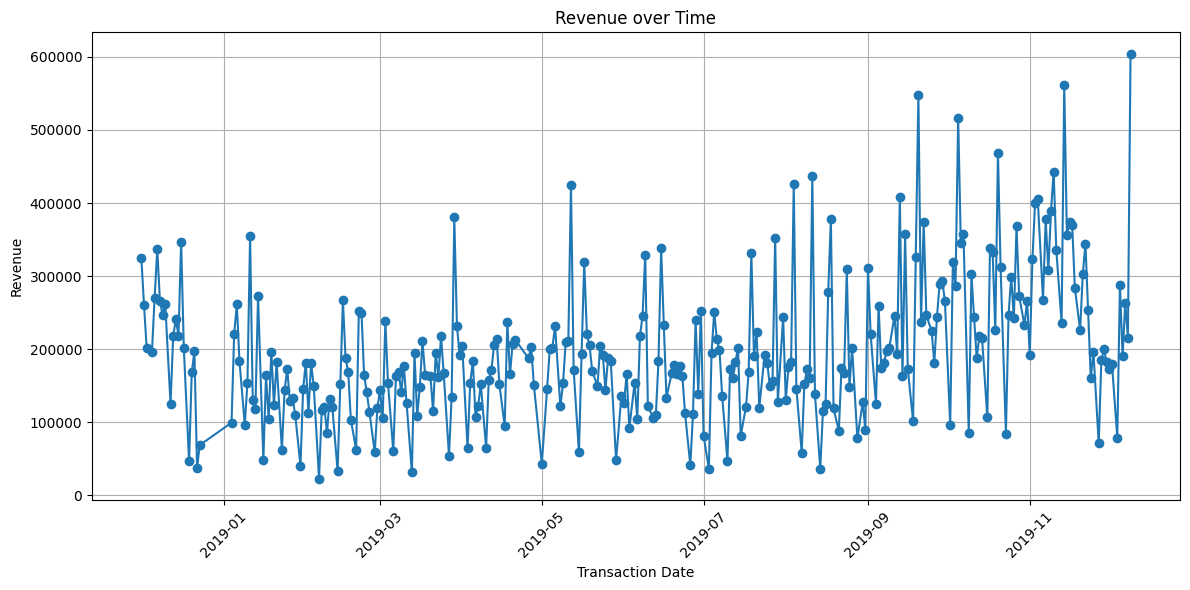

In [13]:
# Grouping Revenue sum by transaction Date in order to plot
revenue_by_date = df.groupby('Transaction_Date')['Revenue'].sum().reset_index()

# We use matplotlib for the plotting
plt.figure(figsize=(12, 6))
plt.plot(revenue_by_date['Transaction_Date'], revenue_by_date['Revenue'], marker='o')
plt.title('Revenue over Time')
plt.xlabel('Transaction Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

### Immediate Patterns and Insights from the Time Series Plot:
1. **Seasonal Spikes:** The revenue shows periodic spikes, especially around the middle of each month (e.g., March, May, and September).
2. **Increasing Trend:** There is an overall upward trend, with revenue increasing significantly in the second half of the year (July onwards).
3. **High Volatility:** The revenue fluctuates widely within short periods, indicating volatile sales patterns.
4. **Consistent Growth:** Despite the volatility, the general direction of the revenue seems to grow steadily towards the end of the year.


## Question 1.3

Let’s continue to analyse on the transaction_date vs revenue.


### Question 1.3.1
Determine which workday (day of the week), generates the most sales (plotting the results in a line chart with workday on averaged revenues).


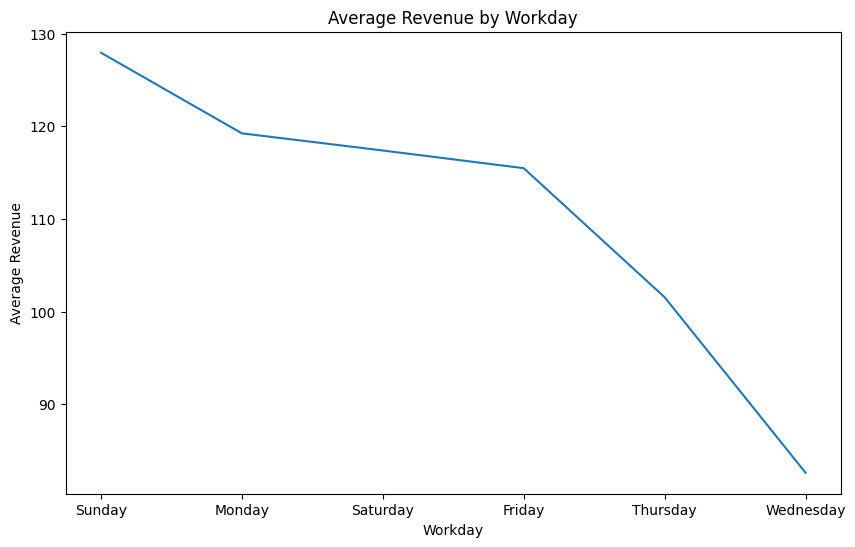

In [14]:
# Task 1.3.1: Extract workday from transaction date
df['Workday'] = df['Transaction_Date'].dt.day_name()

# Group by workday and calculate average revenue
Average_Revenue_by_Workday = df.groupby('Workday')['Revenue'].mean().sort_values(ascending=False)

# Plotting the average revenue by workday
plt.figure(figsize=(10,6))
Average_Revenue_by_Workday.plot(kind='line')
plt.title('Average Revenue by Workday')
plt.xlabel('Workday')
plt.ylabel('Average Revenue')
plt.show()

In [15]:
# We group the data by weekday to find the average revenue and visualize the results using a line plot.

In [16]:
# Output the workday with the highest revenue
most_profitable_workday = Average_Revenue_by_Workday.idxmax()
most_profitable_workday

'Sunday'

### Question 1.3.2
Identify the name of product (column productName_process) that contributes the highest revenue on ‘that workday’ (you need to find out from 1.3.1) and the name of product (column productName_process) that has the highest sales volume (sum of the Quantity), no need to remove negative quantity transactions.) on ‘that workday’ (you need to find out from 1.3.1).


In [17]:
# Task 1.3.2: Names of the products that contribute to highest Revenue and Sales Volume on that Working Day

In [18]:
# Filter the dataset for the most profitable workday
most_profitable_day_df = df[df['Workday'] == most_profitable_workday]

# Find the product with the highest revenue
top_revenue_product = most_profitable_day_df.groupby('productName_process')['Revenue'].sum().idxmax()

# Find the product with the highest sales volume (sum of Quantity)
top_sales_volume_product = most_profitable_day_df.groupby('productName_process')['Quantity'].sum().idxmax()

print(f"The highest revenue product on {most_profitable_workday} is {top_revenue_product}")
print(f"The highest sales volume product on {most_profitable_workday} is {top_sales_volume_product}")

The highest revenue product on Sunday is WorldWarGlidersAsstdDesigns
The highest sales volume product on Sunday is WorldWarGlidersAsstdDesigns


### Question 1.3.3
Please provide two plots showing the top 5 products that contribute the highest revenues in general and top 5 products that have the highest sales volumes in general.

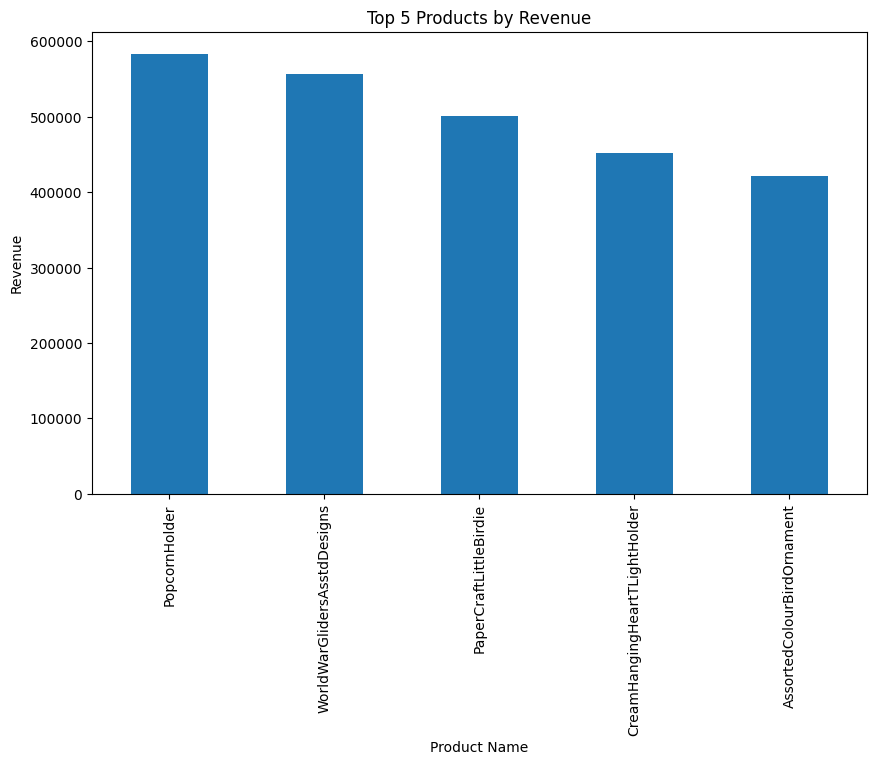

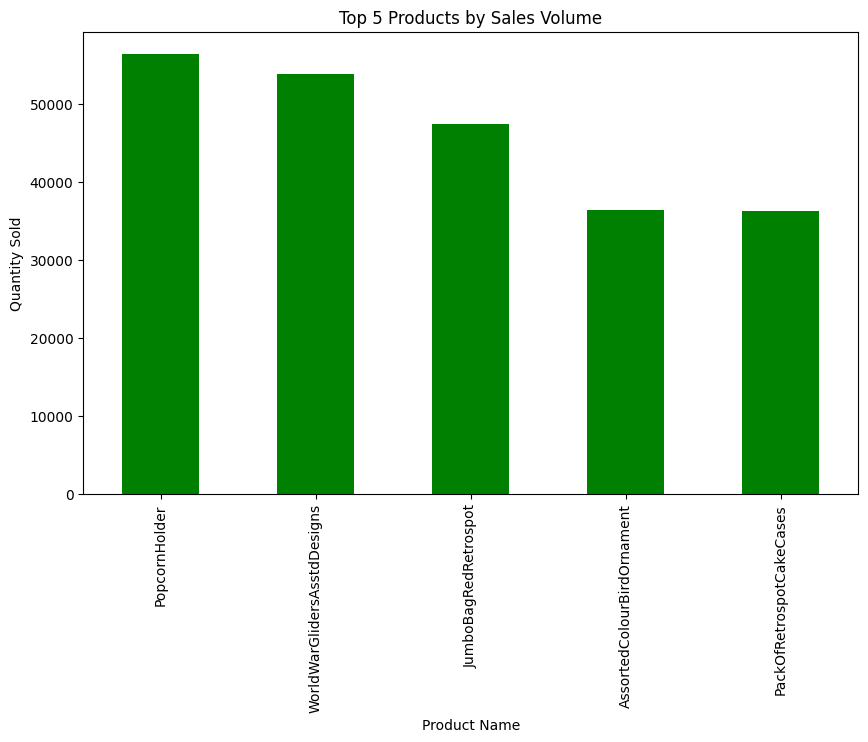

In [19]:
# 1.3.3 Plot the top 5 products contributing to the highest revenues and sales volumes

# Top 5 products by revenue
top_5_revenue_products = df.groupby('productName_process')['Revenue'].sum().nlargest(5)

# Top 5 products by sales volume
top_5_sales_products = df.groupby('productName_process')['Quantity'].sum().nlargest(5)

# Plotting top 5 revenue products
plt.figure(figsize=(10,6))
top_5_revenue_products.plot(kind='bar')
plt.title('Top 5 Products by Revenue')
plt.xlabel('Product Name')
plt.ylabel('Revenue')
plt.show()

# Plotting top 5 sales products
plt.figure(figsize=(10,6))
top_5_sales_products.plot(kind='bar', color='green')
plt.title('Top 5 Products by Sales Volume')
plt.xlabel('Product Name')
plt.ylabel('Quantity Sold')
plt.show()

## Task 1.4
Which country generates the highest revenue? Additionally, identify the month in that country that has
the highest revenue.

In [20]:
#We group the data by Country and calculate total revenue per country to identify the one with the highest revenue.
#Then, we identify the month within that country that has the highest revenue.

# Group by Country and sum the revenue
country_revenue = df.groupby('Country')['Revenue'].sum()

# Find the country with the highest revenue
top_country = country_revenue.idxmax()

# Filter the data for that country
country_df = df[df['Country'] == top_country]

# Extract the full month name from the transaction_date column
country_df['Month'] = country_df['Transaction_Date'].dt.strftime('%B')

# Group by month and calculate revenue
revenue_by_month = country_df.groupby('Month')['Revenue'].sum()

# Find the month with the highest revenue
top_month = revenue_by_month.idxmax()

print(f"The country with the highest revenue is {top_country}")
print(f"The month with the highest revenue in {top_country} is {top_month}")

The country with the highest revenue is United Kingdom
The month with the highest revenue in United Kingdom is November


##Task 1.5

Let’s do some analysis on the CustomerNo and their transactions. Determine the shopping frequency of customers to identify who shops most frequently (find out the highest distinct count of transactionNo
on customer level, be careful with those transactions that is not for shopping – filter those transaction quantity <= 0). Also, find out what products (column productName_process) ‘this customer’ typically buys based on the Quantity of products purchased.


In [21]:
# Task 1.5: Shopping frequency and most purchased products
# Remove transactions with Quantity <= 0
shopping_df = df[df['Quantity'] > 0]

# Group by CustomerNo and count distinct transactions
customer_freq = shopping_df.groupby('CustomerNo')['TransactionNo'].nunique()

# Find the customer with the highest shopping frequency
most_frequent_customer = customer_freq.idxmax()
most_frequent_customers_no_of_transactions = customer_freq.max()

# Filter for this customer and identify their typical products based on Quantity
customer_products = shopping_df[shopping_df['CustomerNo'] == most_frequent_customer]
top_products = customer_products.groupby('productName_process')['Quantity'].sum().nlargest(20)

print(f"The most frequent customer is {most_frequent_customer} with {most_frequent_customers_no_of_transactions} transaction")
print("\n")
print(f"Top products purchased by this customer:\n{top_products}")

The most frequent customer is 12748 with 207 transaction


Top products purchased by this customer:
productName_process
VictorianMetalPostcardSpring       595
WorldWarGlidersAsstdDesigns        480
RoseScentCandleJewelledDrawer      408
CartoonPencilSharpeners            405
SmallWhiteRetrospotMugInBox        390
VanillaScentCandleJewelledBox      380
SmallRedRetrospotMugInBox          372
BubblegumRingAssorted              318
PopartWoodenPencilsAsst            300
OceanScentCandleInJewelledBox      225
AssortedCreepyCrawlies             216
PensAssortedFunnyFace              216
GarageKeyFob                       174
MarieAntoinetteTrinketBoxSilver    168
KeyFobShed                         164
BrocadeRingPurse                   158
WrapChristmasScreenPrint           150
JazzHeartsPurseNotebook            147
PopcornHolder                      147
BeadedChandelierTLightHolder       144
Name: Quantity, dtype: int32


## Question1.6

As the data scientist, you would like to build a basket-level analysis on the product customer buying (filter the ‘df’ dataframe with df[’Quantity’]>0). In this task, you need to:

### Question 1.6.1
Group by the transactionNo and aggregate the category of product (column product_category) into list on transactionNo level. Similarly, group and aggregate name of product (column productName_process) into list on transactionNo level.


In [22]:
# Grouping by transactionNo and aggregating product_category and productName_process into lists
basket_df = shopping_df.groupby('TransactionNo').agg({
    'Product_category': lambda x: list(x),
    'productName_process': lambda x: list(x)
}).reset_index()

# Show the top 5 rows
basket_df.head(10)

,TransactionNo,Product_category,productName_process
0,536365,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca]","[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
1,536366,"[0ca, 0ca]","[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[AssortedColourBirdOrnament, PoppysPlayhouseBe..."
3,536368,"[0ca, 0ca, 0ca, 0ca]","[JamMakingSetWithJars, RedCoatRackParisFashion..."
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[AlarmClockBakelikePink, AlarmClockBakelikeRed..."
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,"[0ca, 0ca]","[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,"[0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, 0ca, ...","[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
9,536374,[0ca],[VictorianSewingBoxLarge]


### Question 1.6.2
Removing duplicates on adjacent elements in the list from product_category you obtained from 1.6.1, such as [product category 1, product category 1, product category 2, ...] will be processed as
[product category 1, product category 2,....]. After this processing, there will be no duplicates on on adjacent elements in the list. Please save your processed dataframe as ‘df_1’ and print the top 10
 rows.

In [23]:
# Function to remove adjacent duplicates in a list
def remove_adjacent_duplicates(lst):
    return [v for i, v in enumerate(lst) if i == 0 or v != lst[i-1]]

# Applying the function to remove adjacent duplicates from product_category
basket_df['Product_category'] = basket_df['Product_category'].apply(remove_adjacent_duplicates)


# Save the processed DataFrame as df_1 and show the top 10 rows
df_1 = basket_df.copy()
df_1.head(10)

,TransactionNo,Product_category,productName_process
0,536365,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
1,536366,[0ca],"[HandWarmerUnionJack, HandWarmerRedRetrospot]"
2,536367,[0ca],"[AssortedColourBirdOrnament, PoppysPlayhouseBe..."
3,536368,[0ca],"[JamMakingSetWithJars, RedCoatRackParisFashion..."
4,536369,[0ca],[BathBuildingBlockWord]
5,536370,[0ca],"[AlarmClockBakelikePink, AlarmClockBakelikeRed..."
6,536371,[0ca],[PaperChainKitSChristmas]
7,536372,[0ca],"[HandWarmerRedRetrospot, HandWarmerUnionJack]"
8,536373,[0ca],"[CreamHangingHeartTLightHolder, WhiteMoroccanM..."
9,536374,[0ca],[VictorianSewingBoxLarge]


## Question 1.7

Continue work on the results of question 1.6, now for each of the transaction, you will have a list of
product categories. To further conduct the analysis, you need to finish below by using dataframe
‘df_1’:

### Question 1.7.1
Create new column prod_len to find out the length of the list from product_category on each
transaction. Print the first five rows of dataframe ‘df_1’.

In [24]:
# Create a new column for the length of product_category list
df_1['Prod_Len'] = df_1['Product_category'].apply(len)

# Show the first five rows
df_1[['TransactionNo', 'Product_category', 'Prod_Len']].head()


,TransactionNo,Product_category,Prod_Len
0,536365,[0ca],1
1,536366,[0ca],1
2,536367,[0ca],1
3,536368,[0ca],1
4,536369,[0ca],1


### Question 1.7.2
Transform the list in product_category from [productcategory1, productcategory2...] to ‘start >
productcategory1 > productcategory2 > ... > conversion’ with new column path. You need to add
‘start’ as the first element, and ‘conversion’ as the last. Also you need to use ‘ > ’ to connect each of
the transition on products (there is a space between the elements and the transition symbol >).
The final format after the transition is given in example as below fig. 2. Define the function
data_processing to achieve above with three arguments: df which is the dataframe name,
maxlength with default value of 3 for filtering the dataframe with prod_len" <=maxlength and
minlength with default value of 1 for filtering the dataframe with prod_len >=minlength. The
function data_processing will return the new dataframe ‘df_2’. Run your defined function with
dataframe ‘df_1’, maxlength = 5 and minlength = 2, print the dataframe ‘df_2’ with top 10 rows.

In [25]:
# Function to transform product_category into the desired path format
def data_processing(df, maxlength=3, minlength=1):
    df_filtered = df[(df['Prod_Len'] <= maxlength) & (df['Prod_Len'] >= minlength)]
    df_filtered['path'] = df_filtered['Product_category'].apply(lambda x: 'start > ' + ' > '.join(x) + ' > conversion')
    return df_filtered

# Applying the function with maxlength=5 and minlength=2
df_2 = data_processing(df_1, maxlength=5, minlength=2)

# Show the top 10 rows of the new dataframe
df_2.head(10)

,TransactionNo,Product_category,productName_process,Prod_Len,path
13,536378,"[0ca, 1ca, 0ca]","[StrawberryCharlotteBag, ChildrensCutleryRetro...",3,start > 0ca > 1ca > 0ca > conversion
27,536395,"[0ca, 1ca, 0ca]","[BlackHeartCardHolder, AssortedColourBirdOrnam...",3,start > 0ca > 1ca > 0ca > conversion
36,536404,"[0ca, 1ca, 0ca, 4ca, 0ca]","[HeartIvoryTrellisSmall, ClearDrawerKnobAcryli...",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion
40,536408,"[0ca, 1ca, 0ca]","[MagicDrawingSlateDinosaur, MagicDrawingSlateB...",3,start > 0ca > 1ca > 0ca > conversion
42,536412,"[0ca, 4ca, 0ca]","[RoundSnackBoxesSetOfWoodland, RoundSnackBoxes...",3,start > 0ca > 4ca > 0ca > conversion
43,536415,"[0ca, 1ca, 0ca]","[CakeCasesVintageChristmas, PaperChainKitVinta...",3,start > 0ca > 1ca > 0ca > conversion
52,536464,"[0ca, 1ca, 0ca]","[BlackSweetheartBracelet, DiamanteHairGripPack...",3,start > 0ca > 1ca > 0ca > conversion
72,536532,"[0ca, 1ca, 0ca]","[BoxOfCocktailParasols, GrowYourOwnPlantInACan...",3,start > 0ca > 1ca > 0ca > conversion
82,536542,"[0ca, 4ca]","[RecyclingBagRetrospot, JumboStorageBagSkulls,...",2,start > 0ca > 4ca > conversion
83,536544,"[0ca, 1ca, 0ca, 4ca, 0ca]","[DecorativeRoseBathroomBottle, DecorativeCatsB...",5,start > 0ca > 1ca > 0ca > 4ca > 0ca > conversion


## Question 1.8
Continue to work on the results of question 1.7, the dataframe ‘df_2’, we would like to build the
transition matrix together, but before we actually conduct the programming, we will need to finish few
questions for exploration:


### Question 1.8.1
Check on your transaction level basket with results from question 1.7, could you please find out
respectively how many transactions ended with pattern ‘... > 0ca > conversion’ / ‘...
> 1ca > conversion’ / ‘... > 2ca > conversion’ / ‘... > 3ca > conversion’ / ‘... > 4ca > conversion’ (1 result
for each pattern, total 5 results are expected).


In [26]:
# Count the number of transactions ending with each specific pattern
patterns = ['0ca > conversion', '1ca > conversion', '2ca > conversion', '3ca > conversion', '4ca > conversion']
pattern_results = {}

# Check how many transactions end with these patterns
for pattern in patterns:
    count = df_2['path'].apply(lambda x: x.endswith(pattern)).sum()
    print(f"Number of transactions ending with '{pattern}': {count}")

Number of transactions ending with '0ca > conversion': 3056
Number of transactions ending with '1ca > conversion': 26
Number of transactions ending with '2ca > conversion': 144
Number of transactions ending with '3ca > conversion': 68
Number of transactions ending with '4ca > conversion': 198


### Question 1.8.2
Check on your transaction level basket with results from question 1.7, could you please find out
respectively how many times the transactions contains ‘0ca > 0ca’ / ‘0ca > 1ca’ / ‘0ca > 2ca’ / ‘0ca
> 3ca’ / ‘0ca > 4ca’ / ‘0ca > conversion’ in the whole data (1 result for each pattern, total 6 results
are expected and each transaction could contain those patterns multiple times, such as ‘start >
0ca > 1ca > 0ca > 1ca > conversion’ will count ‘two’ times with pattern ‘0ca > 1ca’, if there is not any,
then return 0, you need to sum the counts from each transaction to return the final value).


In [27]:
# Count occurrences of specific patterns in the path
transition_patterns = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
transition_results = {}


# Count occurrences of each pattern within the path and sum them up
for pattern in transition_patterns:
    count = df_2['path'].apply(lambda x: x.count(pattern)).sum()
    print(f"Total occurrences of '{pattern}' in all transactions: {count}")

Total occurrences of '0ca > 0ca' in all transactions: 0
Total occurrences of '0ca > 1ca' in all transactions: 1222
Total occurrences of '0ca > 2ca' in all transactions: 1137
Total occurrences of '0ca > 3ca' in all transactions: 343
Total occurrences of '0ca > 4ca' in all transactions: 1198
Total occurrences of '0ca > conversion' in all transactions: 3056


### Question 1.8.3
Check on your transaction level basket with results from task question 1.7, could you please find
out how many times the transactions contains ‘...> 0ca > ...’ in the whole data (1 result is expected
and each transaction could contain the pattern multiple times, such as ‘start
> 0ca > 1ca > 0ca > 1ca > conversion’ will count ‘two’ times, you need to sum the counts from each
transaction to return the final value).


In [28]:
# Count how many times the path contains '... > 0ca > ...'
pattern_occurrences = df_2['path'].str.count('> 0ca >').sum()
print(f"Total occurrences of the pattern '... > 0ca > ...' in all transactions: {pattern_occurrences}")


Total occurrences of the pattern '... > 0ca > ...' in all transactions: 6956


### Question 1.8.4
Use the 6 results from 1.8.2 to divide the result from 1.8.3 and then sum all of them and return the
value.

In [29]:

# Transition patterns from 1.8.2
transition_patterns = ['0ca > 0ca', '0ca > 1ca', '0ca > 2ca', '0ca > 3ca', '0ca > 4ca', '0ca > conversion']
transition_results = {}

# Count occurrences of each pattern within the path and sum them up (from 1.8.2)
for pattern in transition_patterns:
    count = df_2['path'].apply(lambda x: x.count(pattern)).sum()
    transition_results[pattern] = count
    print(f"Total occurrences of '{pattern}' in all transactions: {count}")

# Total occurrences of '... > 0ca > ...' in all transactions (from 1.8.3)
total_zero_ca_occurrences = df_2['path'].str.count('> 0ca >').sum()
print(f"Total occurrences of the pattern '... > 0ca > ...' in all transactions: {total_zero_ca_occurrences}")

# 1.8.4: Divide the results from 1.8.2 by 1.8.3
# Initialize a dictionary to store ratios
pattern_ratios = {}

# Calculate the ratios for each pattern
for pattern, count in transition_results.items():
    if total_zero_ca_occurrences > 0:  # Avoid division by zero
        pattern_ratios[pattern] = count / total_zero_ca_occurrences
    else:
        pattern_ratios[pattern] = 0  # If there are no occurrences of '0ca >', set ratio to 0


print("\n")

# Print each ratio
for pattern, ratio in pattern_ratios.items():
    print(f"Ratio of '{pattern}' to total '... > 0ca > ...' occurrences: {ratio}")


# Sum all the ratios
total_ratio_sum = sum(pattern_ratios.values())

print("\n")
print(f"Total sum of all ratios: {total_ratio_sum}")

Total occurrences of '0ca > 0ca' in all transactions: 0
Total occurrences of '0ca > 1ca' in all transactions: 1222
Total occurrences of '0ca > 2ca' in all transactions: 1137
Total occurrences of '0ca > 3ca' in all transactions: 343
Total occurrences of '0ca > 4ca' in all transactions: 1198
Total occurrences of '0ca > conversion' in all transactions: 3056
Total occurrences of the pattern '... > 0ca > ...' in all transactions: 6956


Ratio of '0ca > 0ca' to total '... > 0ca > ...' occurrences: 0.0
Ratio of '0ca > 1ca' to total '... > 0ca > ...' occurrences: 0.17567567567567569
Ratio of '0ca > 2ca' to total '... > 0ca > ...' occurrences: 0.16345600920069006
Ratio of '0ca > 3ca' to total '... > 0ca > ...' occurrences: 0.04930994824611846
Ratio of '0ca > 4ca' to total '... > 0ca > ...' occurrences: 0.17222541690626797
Ratio of '0ca > conversion' to total '... > 0ca > ...' occurrences: 0.43933294997124783


Total sum of all ratios: 1.0


## Question 1.9

Let’s now look at the question 1.6 again, you have the list of product and list of product category for
each transaction. We will use the transactionNo and productName_process to conduct the Association
rule learning.


### Question 1.9.1
Work on the dataframe df from question 1.2 (filter out the transaction with negative quantity
value and also only keep those top 100 products by ranking the sum of quantity) and build the
transaction level product dataframe (each row represents transactionNo and
productName_process become the columns, the value in the column is the Quantity). Hint: you
might consider to use pivot function in pandas.

In [30]:
# Filter out negative quantity values and keep only the top 100 products
filtered_df = df[df['Quantity'] > 0]
top_100_products = filtered_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter the dataframe for the top 100 products
filtered_df = filtered_df[filtered_df['productName_process'].isin(top_100_products)]

# Create the transaction level product dataframe using pivot
transaction_df = filtered_df.pivot_table(index='TransactionNo', columns='productName_process', values='Quantity', fill_value=0)

# Show the first 5 rows
transaction_df.head()

productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
TransactionNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,32.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536371,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Question 1.9.2
Run the apriori algorithm to identify items with minimum support of 1.5% (only looking at
baskets with 4 or more items).
Hint: you might consider to use mlxtend.frequent_patterns to run apriori rules


In [31]:
# Convert the DataFrame values to boolean (1 if Quantity > 0, else 0)
transaction_bool_df = transaction_df.applymap(lambda x: 1 if x > 0 else 0)

# Apply the apriori algorithm with a minimum support of 1.5%
frequent_itemsets = apriori(transaction_bool_df, min_support=0.015, use_colnames=True)

# Show the frequent itemsets
frequent_itemsets.head()

,support,itemsets
0,0.021994,(AgedGlassSilverTLightHolder)
1,0.058542,(AntiqueSilverTLightGlass)
2,0.094249,(AssortedColourBirdOrnament)
3,0.033508,(AssortedColoursSilkFan)
4,0.036872,(BaggSwirlyMarbles)


### Question 1.9.3
Run the apriori algorithm to find the items with support >= 1.0% and lift > 10.


In [32]:
# Apply the apriori algorithm with a minimum support of 1%
frequent_itemsets = apriori(transaction_bool_df, min_support=0.01, use_colnames=True)

# Generate the association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=10)

# Filter rules with support >= 1%
filtered_rules = rules[rules['support'] >= 0.01]

# Display the filtered rules
filtered_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(CharlotteBagPinkPolkadot),(RedRetrospotCharlotteBag),0.048063,0.066887,0.033767,0.702557,10.503706,0.030552,3.137119,0.950478
1,(RedRetrospotCharlotteBag),(CharlotteBagPinkPolkadot),0.066887,0.048063,0.033767,0.504836,10.503706,0.030552,1.922467,0.969652
2,(CharlotteBagPinkPolkadot),(StrawberryCharlotteBag),0.048063,0.046704,0.024516,0.510094,10.921809,0.022272,1.945876,0.954307
3,(StrawberryCharlotteBag),(CharlotteBagPinkPolkadot),0.046704,0.048063,0.024516,0.524931,10.921809,0.022272,2.003787,0.952947
4,(CharlotteBagSukiDesign),(StrawberryCharlotteBag),0.057054,0.046704,0.026845,0.470522,10.074505,0.024181,1.800443,0.955240


### Question 1.9.4
Please explore three more examples with different support / confidence / lift measurements
(you could leverage your rule mining with one of the three measurements or all of them) to find
out any of the interesting patterns from the Association rule learning. Save your code and
results in a clean and tidy format and writing down your insights.

In [33]:
# Example 1: Higher confidence (min_threshold=0.8) and support >= 2%
rules_conf_0_8 = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.8)
rules_conf_0_8 = rules_conf_0_8[rules_conf_0_8['support'] >= 0.02]

# Example 2: Lower lift threshold (min_threshold=8) and confidence >= 0.7
rules_lift_8 = association_rules(frequent_itemsets, metric="lift", min_threshold=8)
rules_lift_8 = rules_lift_8[rules_lift_8['confidence'] >= 0.7]

# Example 3: Higher support (min_threshold=0.02) and lift >= 12
rules_support_0_02 = association_rules(frequent_itemsets, metric="support", min_threshold=0.02)
rules_support_0_02 = rules_support_0_02[rules_support_0_02['lift'] >= 12]

# Display the first few rows of each rule set with proper headings and line breaks

print("Rules with Confidence ≥ 0.8 and Support ≥ 2%:")
print(rules_conf_0_8.head())
print("\n" + "-"*50 + "\n")

print("Rules with Lift ≥ 8 and Confidence ≥ 0.7:")
print(rules_lift_8.head())
print("\n" + "-"*50 + "\n")

print("Rules with Support ≥ 2% and Lift ≥ 12:")
print(rules_support_0_02.head())
print("\n" + "-"*50 + "\n")

Rules with Confidence ≥ 0.8 and Support ≥ 2%:
                                          antecedents  \
0   (CharlotteBagSukiDesign, CharlotteBagPinkPolka...   
9   (CharlotteBagPinkPolkadot, StrawberryCharlotte...   
10   (WoodlandCharlotteBag, CharlotteBagPinkPolkadot)   
11   (CharlotteBagSukiDesign, StrawberryCharlotteBag)   
16  (JumboBagPinkPolkadot, JumboBagScandinavianBlu...   

                   consequents  antecedent support  consequent support  \
0   (RedRetrospotCharlotteBag)            0.026522            0.066887   
9   (RedRetrospotCharlotteBag)            0.024516            0.066887   
10  (RedRetrospotCharlotteBag)            0.025551            0.066887   
11  (RedRetrospotCharlotteBag)            0.026845            0.066887   
16      (JumboBagRedRetrospot)            0.024711            0.135326   

     support  confidence       lift  leverage  conviction  zhangs_metric  
0   0.021282    0.802439  11.997007  0.019508    4.723167       0.941619  
9   0.021088    

## Question 1.10

After we finished the Association rule learning, it is a time for us to consider to do customer analysis
based on their shopping behaviours.


### Question 1.10.1
Work on the dataframe df from question 1.2 and build the customer product dataframe
(each row represents single customerNo and productName_process become as the columns, the
value in the columns is the aggregated Quantity value from all transactions and the result is a N
by M matrix where N is the number of distinct customerNo and M is the number of distinct
productName_process. Please filter out the transaction with negative quantity value and also only
keep those top 100 product by ranking the sum of quantity).


In [34]:
# Filter out negative quantity values and keep the top 100 products
filtered_customer_df = df[df['Quantity'] > 0]
top_100_products = filtered_customer_df.groupby('productName_process')['Quantity'].sum().nlargest(100).index

# Filter for the top 100 products
filtered_customer_df = filtered_customer_df[filtered_customer_df['productName_process'].isin(top_100_products)]

# Create the customer-product dataframe (N by M matrix)
customer_product_df = filtered_customer_df.pivot_table(index='CustomerNo', columns='productName_process', values='Quantity', aggfunc='sum', fill_value=0)

# Show the first 5 rows
customer_product_df.head()

productName_process,AgedGlassSilverTLightHolder,AntiqueSilverTLightGlass,AssortedColourBirdOrnament,AssortedColoursSilkFan,AssortedFlowerColourLeis,AsstdDesigndPaperStickers,BaggSwirlyMarbles,BlackRecordCoverFrame,BrocadeRingPurse,BubblegumRingAssorted,...,StrawberryCharlotteBag,SweetheartFairyCakeCases,TeatimeFairyCakeCases,TravelCardWalletKeepCalm,VictorianGlassHangingTLight,VintageSnapCards,WoodenHeartChristmasScandinavian,WoodenStarChristmasScandinavian,WoodlandCharlotteBag,WorldWarGlidersAsstdDesigns
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12008,1,40,0,0,0,0,0,0,0,0,...,0,0,0,0,3,2,0,0,0,0
12025,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12026,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,0,0,0,0,1,1
12031,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Question 1.10.2
Use the customer-product dataframe, let’s calculate the Pairwise Euclidean distance on
customer level (you will need to use the product Quantity information on each customer to
calculate the Euclidean distance for all other customers and the result is a N by N matrix where
N is the number of distinct customerNo).


In [35]:
# Calculate the Euclidean distance between customers
customer_distances = euclidean_distances(customer_product_df)

# Convert the distances into a DataFrame for easier manipulation
distance_df = pd.DataFrame(customer_distances, index=customer_product_df.index, columns=customer_product_df.index)

# Show the distance matrix
distance_df.head()

CustomerNo,12004,12008,12025,12026,12031,12042,12043,12050,12057,12063,...,18269,18270,18272,18274,18276,18277,18281,18282,18283,18287
CustomerNo,,,,,,,,,,,,,,,,,,,,,
12004,0.000000,42.130749,13.152946,10.049876,9.949874,22.068076,19.416488,8.426150,33.852622,8.774964,...,22.516660,14.798649,136.216739,20.000000,48.445846,28.548205,13.228757,14.000000,99.005050,42.649736
12008,42.130749,0.000000,43.474130,41.737274,42.308392,46.130250,44.384682,41.737274,53.656314,42.000000,...,47.853944,43.657760,139.807010,45.683695,45.978256,50.019996,43.150898,43.116122,107.791465,59.816386
12025,13.152946,43.474130,0.000000,15.231546,9.899495,24.859606,19.390719,13.266499,32.326460,14.142136,...,27.820855,18.493242,137.542721,22.869193,49.699095,30.626786,17.262677,17.860571,97.483332,45.144213
12026,10.049876,41.737274,15.231546,0.000000,9.695360,20.542639,21.954498,6.782330,37.080992,6.000000,...,24.698178,13.341664,135.535973,18.947295,48.020829,27.820855,11.575837,12.449900,99.413279,43.011626
12031,9.949874,42.308392,9.899495,9.695360,0.000000,22.181073,20.248457,7.211103,33.985291,7.874008,...,25.219040,14.282857,137.040140,19.621417,48.290786,28.284271,12.649111,13.453624,99.191734,43.588989


### Question 1.10.3
Use the customer Pairwise Euclidean distance to find out the top 3 most similar customer to
CustomerNo == 13069 and CustomerNo == 17490.


In [36]:
# Find the top 3 similar customers to CustomerNo 13069
top_3_customers_13069 = distance_df.loc['13069'].nsmallest(4).iloc[1:4].index.tolist()

# Find the top 3 similar customers to CustomerNo 17490
top_3_customers_17490 = distance_df.loc['17490'].nsmallest(4).iloc[1:4].index.tolist()

print("Top 3 most similar customers to 13069:", top_3_customers_13069)
print("Top 3 most similar customers to 17490:", top_3_customers_17490)

Top 3 most similar customers to 13069: ['15118', '17523', '18179']
Top 3 most similar customers to 17490: ['12519', '12582', '12652']


### Question 1.10.4
For the customer CustomerNo == 13069, you could see there are some products that this
customer has never shopped before, could you please give some suggestions on how to
recommend these product to this customer? please write down your suggestions and provide a
coding logic (steps on how to achieve, not actual code).


### Suggestions for Reccommendations:

1. **Collaborative Filtering (User-Based):**
Use the purchasing patterns of similar customers to recommend products that CustomerNo 13069 hasn't purchased yet. This method identifies products frequently bought by customers with similar purchase histories, assuming that CustomerNo 13069 might also be interested in those products.

2. **Product-Based Filtering:**
Identify products that are frequently purchased together with products CustomerNo 13069 has bought. This approach assumes that products commonly bought together might be of interest to the customer.

3. **Association Rule Mining:**
Apply association rule mining to find strong relationships between products. If certain products are frequently purchased by customers who bought similar items as CustomerNo 13069, those products could be recommended.

4. **Top-Selling Products Among Similar Customers:**
Recommend products that are the most popular among customers similar to CustomerNo 13069 but haven't been purchased by this customer yet.

### Coding Logic for Recommendations:

1. **Collaborative Filtering (User-Based):**
 - Step 1: Retrieve products bought by CustomerNo 13069.
 - Step 2: Identify top 3 most similar customers using Euclidean distance.
 - Step 3: Find products bought by similar customers but not by 13069.
 - Step 4: Recommend the top-ranked products based on frequency among similar customers.

2. **Product-Based Filtering:**
 - Step 1: Identify products bought by 13069.
 - Step 2: Use product co-occurrence to find products frequently bought together with 13069's purchases.
 - Step 3: Recommend top co-purchased products.

3. **Association Rule Mining:**
 - Step 1: Apply association rules on all transactions.
 - Step 2: Identify rules where 13069's purchased products appear in the antecedents.
 - Step 3: Recommend products in the consequents of strong rules.

4. **Top-Selling Products Among Similar Customers:**
 - Step 1: Get the most popular products among similar customers.
 - Step 2: Filter out products already bought by 13069.
 - Step 3: Recommend the top-selling unpurchased products.

# Part 2: Sales Prediction



## Question 2.1: Explore Revenue Time Series and Decompose for Seasonality

You are required to explore the revenue time series. There are some days not available in the revenue
time series such as 2019-01-01. Please add those days into the revenue time series with default revenue
value with the mean value of the revenue in the whole data (without any filtering on transactions).
After that, decompose the revenue time series with addictive mode and analyses on the results to find
if there is any seasonality pattern (you could leverage the M05A material from lab session with default
setting in seasonal_decompose function).


Average Daily Revenue: 197639.421875
Revenue Time Series (First 10 rows):
                   Revenue
Date                     
2018-12-01  324649.218750
2018-12-02  260301.656250
2018-12-03  201975.187500
2018-12-04  197639.421875
2018-12-05  196630.796875
2018-12-06  270656.875000
2018-12-07  336505.875000
2018-12-08  265961.593750
2018-12-09  247149.875000
2018-12-10  262008.187500


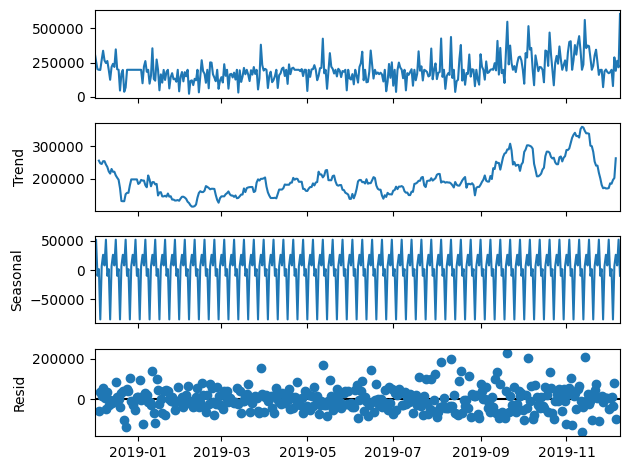

In [37]:
# Step 1: Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Step 2: Group the data by 'Date' and calculate total revenue per day
revenue_ts = df.groupby('Date')['Revenue'].sum().reset_index()

# Step 3: Set 'Date' as the index for easier time series manipulation
revenue_ts.set_index('Date', inplace=True)

# Step 4: Calculate the average daily revenue
avg_revenue = revenue_ts['Revenue'].mean()
print(f"Average Daily Revenue: {avg_revenue}")

# Step 5: Create a complete date range from the earliest to the latest date
full_date_range = pd.date_range(start=revenue_ts.index.min(), end=revenue_ts.index.max())

# Step 6: Reindex the revenue time series to fill missing dates with the average revenue
revenue_ts = revenue_ts.reindex(full_date_range, fill_value=avg_revenue)
revenue_ts.index.name = 'Date'  # Reset index name after reindexing

# Step 7: Display the first few rows to ensure the dates are filled correctly
print("Revenue Time Series (First 10 rows):\n", revenue_ts.head(10))

# Step 8: Decompose the time series to identify trend, seasonality, and residuals
ts_decomposition = seasonal_decompose(revenue_ts, model='additive')

# Step 9: Plot the decomposed components
ts_decomposition.plot()
plt.show()

## Question 2.2: Time Series Forecasting with ARIMA

We will try to use time series model ARIMA for forecasting the future. you need to find the best model
with different parameters on ARIMA model. The parameter range for p,d,q are all from [0, 1, 2]. In total, you need to find out the best model with lowest Mean Absolute Error from 27 choices based on the time
from ”Jan-01-2019” to ”Nov-01-2019” (you might need to split the time series to train and test with grid
search according to the M05B material).

ARIMA(0,0,0) - MAE: 81191.1997
ARIMA(0,0,1) - MAE: 81198.1665
ARIMA(0,0,2) - MAE: 81179.8356
ARIMA(0,1,0) - MAE: 72537.5464
ARIMA(0,1,1) - MAE: 78569.0030
ARIMA(0,1,2) - MAE: 78583.6370
ARIMA(0,2,0) - MAE: 7444577.7640
ARIMA(0,2,1) - MAE: 72406.4221
ARIMA(0,2,2) - MAE: 72123.1935
ARIMA(1,0,0) - MAE: 81197.3808
ARIMA(1,0,1) - MAE: 81222.6335
ARIMA(1,0,2) - MAE: 81166.1480
ARIMA(1,1,0) - MAE: 78737.9446
ARIMA(1,1,1) - MAE: 78571.8609
ARIMA(1,1,2) - MAE: 78651.1750
ARIMA(1,2,0) - MAE: 880205.2178
ARIMA(1,2,1) - MAE: 104588.4016
ARIMA(1,2,2) - MAE: 80392.3240
ARIMA(2,0,0) - MAE: 81177.6680
ARIMA(2,0,1) - MAE: 81169.4086
ARIMA(2,0,2) - MAE: 80887.3818
ARIMA(2,1,0) - MAE: 77707.7724
ARIMA(2,1,1) - MAE: 78641.2943
ARIMA(2,1,2) - MAE: 78692.0440
ARIMA(2,2,0) - MAE: 1087346.0546
ARIMA(2,2,1) - MAE: 97811.4879
ARIMA(2,2,2) - MAE: 108231.8532
Best ARIMA Model: (0, 2, 2) with MAE: 72123.1935


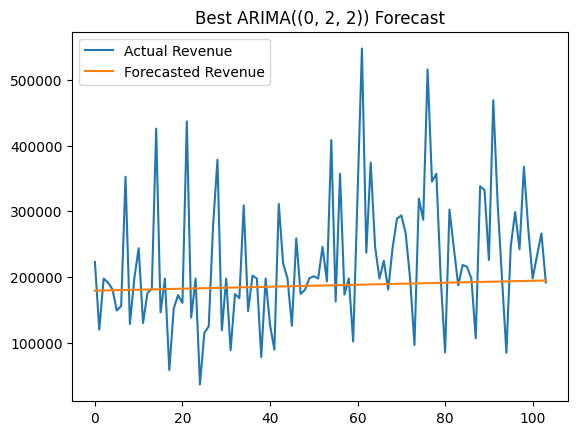

In [38]:
# Step 1: Select the date range for the time series data (January to November 2019)
filtered_ts = revenue_ts['2019-01-01':'2019-11-01']

# Step 2: Convert the data to a NumPy array and define training and testing sets (66% training)
revenue_data = filtered_ts.values.astype('float32')
train_size = int(len(revenue_data) * 0.66)
train_data, test_data = revenue_data[:train_size], revenue_data[train_size:]

# Step 3: Initialize variables for model selection
history = list(train_data)
test_predictions = []
mae_scores = []
best_mae = float('inf')
best_model_params = None

# Step 4: Define parameter ranges for ARIMA (p, d, q) and perform a grid search
p_values = d_values = q_values = range(0, 3)

# Step 5: Perform walk-forward validation for each combination of p, d, q
for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # Fit the ARIMA model with the current (p, d, q) parameters
                model = ARIMA(history, order=(p, d, q))
                model_fit = model.fit()

                # Forecast the next value and save the prediction
                forecast = model_fit.forecast(steps=len(test_data))

                # Calculate the Mean Absolute Error (MAE) for the current model
                current_mae = mean_absolute_error(test_data, forecast)
                mae_scores.append(current_mae)

                # Update the best model parameters if this model performs better
                if current_mae < best_mae:
                    best_mae = current_mae
                    best_model_params = (p, d, q)

                # Print progress for each parameter combination
                print(f'ARIMA({p},{d},{q}) - MAE: {current_mae:.4f}')
            except Exception as e:
                print(f"Failed for ARIMA({p},{d},{q}): {str(e)}")
                continue

# Step 6: Print the best model and its MAE
print(f'Best ARIMA Model: {best_model_params} with MAE: {best_mae:.4f}')

# Step 7: Plot the actual vs forecasted values for the best model
best_model = ARIMA(train_data, order=best_model_params)
best_model_fit = best_model.fit()
best_forecast = best_model_fit.forecast(steps=len(test_data))

plt.plot(test_data, label='Actual Revenue')
plt.plot(best_forecast, label='Forecasted Revenue')
plt.title(f'Best ARIMA({best_model_params}) Forecast')
plt.legend()
plt.show()

##Question 2.3:
There are many deep learning time series forecasting methods, could you please explore those
methods and write down the necessary data wrangling and modeling steps (steps on how to achieve,
not actual code). Also please give the reference of the deep learning time series forecasting models you
are using.


### Deep Learning Time Series Forecasting Methods:
There are several deep learning models designed for time series forecasting, such as LSTM (Long Short-Term Memory), GRU (Gated Recurrent Unit), and Temporal Convolutional Networks (TCN). These models are particularly useful for capturing complex patterns, trends, and seasonality in time series data.

### Key Steps for Data Wrangling and Modeling:
1. **Data Preparation:**
 - **Normalization:** Time series data should be normalized or standardized to ensure that the features are on a similar scale. This is critical for deep learning models.
 - **Sequence Generation:** The data must be transformed into sequences, typically by using a sliding window. For example, use the past 30 days of revenue data to predict the next day's revenue. Split the data into input-output pairs (X, y).
 - **Train-Test Split:** Divide the data into training and testing sets, ensuring the model is trained on past data and tested on unseen future data.
2. **LSTM (Long Short-Term Memory):**
 - **Architecture:** LSTM networks are capable of learning long-term dependencies in sequential data. They are suitable for time series with trends and seasonality.
 - **Input Shape:** The input data should be reshaped into 3D format [samples, time steps, features], where each sample represents a sequence of time steps.
 - **Modeling Steps:**
  Create an LSTM model with input, hidden, and output layers. Compile the model with an optimizer (e.g., Adam) and a loss function (e.g., mean squared error). Train the model on the training data using backpropagation through time.
 - **References:** Hochreiter & Schmidhuber (1997) introduced LSTMs for sequence learning.
3. **GRU (Gated Recurrent Unit):**
 - **Architecture:** GRU is a simplified version of LSTM and is often faster to train while providing similar accuracy. It is suitable for time series with medium complexity.
 - **Input Shape:** Similar to LSTM, GRU models require 3D input data.
 - **Modeling Steps:**
Replace the LSTM layers with GRU layers in the neural network.
Compile and train the model in a similar manner to LSTM.
 - **References:** Cho et al. (2014) introduced GRU as an alternative to LSTM for faster convergence.
4. **Temporal Convolutional Networks (TCN):**
 - **Architecture:** TCNs use causal convolutions and are designed for sequence modeling. They can capture patterns over long sequences without the limitations of recurrent models like LSTM and GRU.
 - **Input Shape:** TCNs also require the input data in 3D format, but the architecture relies on convolutional layers instead of recurrent layers.
 - **Modeling Steps:**
Build a TCN model using stacked convolutional layers.
Apply padding to ensure the network maintains the temporal order of data.
Compile and train the model with an appropriate optimizer and loss function.
 - **References:** Bai et al. (2018) introduced TCNs for sequence learning, demonstrating strong performance in time series tasks.
5. **Model Evaluation:**
After training, evaluate the model performance on the test data using metrics such as mean absolute error (MAE), root mean squared error (RMSE), and mean squared error (MSE).
Perform hyperparameter tuning, adjusting parameters such as the number of layers, learning rate, and batch size, to optimize performance.